In [10]:
import ROOT
from ROOT import TCanvas, TF1, TPaveLabel, TPad, TText
from ROOT import gROOT
from ROOT import TMath
import math

FIT PARAMETES:
    - par[0]=Width (scale) Breit-Wigner
    - par[1]=Most Probable (MP, location) Breit mean
    - par[2]=Total area (integral -inf to inf, normalization constant)
    - par[3]=Width (sigma) of convoluted Gaussian function


1921
#chi^{2}/ndf = 1.229481140583065  prob=  0.12199534313965267
======> EVENT:0
 Zmass           = 80.9184
 Zpt             = 0.883632
 Zeta            = -6.1385
 Zphi            = -1.67533
 Zrapidity       = 1.19323
 Zcharge         = 0
 FCN=65.1625 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=5.68923e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  BW width     2.49500e+00     fixed    
   2  BW mean      9.07994e+01   6.59115e-02   5.20816e-05  -6.94686e-03
   3  Area         2.04210e+03   4.74032e+01   1.88265e-01  -9.79971e-08
   4  Sigma        1.48235e+00   8.60496e-02   3.39689e-04   5.25668e-04


Warning in <TCanvas::Constructor>: Deleting canvas with same name: tc
Info in <TCanvas::Print>: png file Zpeak.png has been created


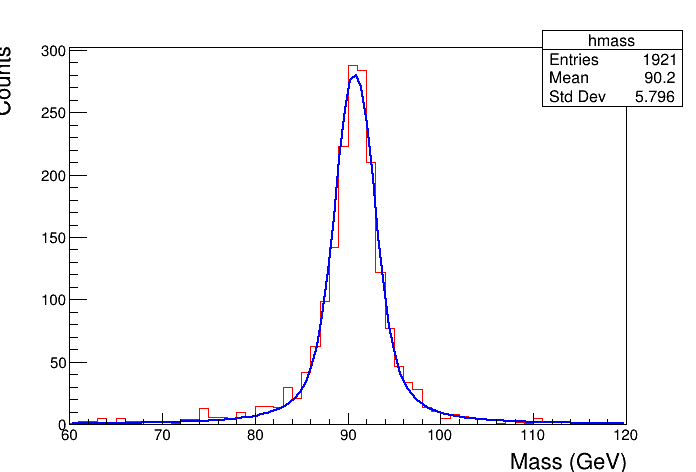

In [11]:

def RBWGaus(x, par):

    np = 100 # #number of convolution steps
    sc = 4 #convolution extends to +-sc Gaussian sigmas

          #Range of convolution integral
    xmin = x[0] - sc * par[3]
    xmax = x[0] + sc * par[3]
    step = (xmax-xmin) / np
    
      # Convolution integral of Breit-Wigner and Gaussian by sum
    sum = 0.0



    for i in range (1, np//2):
        xx = xmin + (i-.5) * step
        fbw = TMath.BreitWigner(xx,par[1],par[0])
        sum += fbw * TMath.Gaus(x[0],xx,par[3])

        xx = xmax - (i-.5) * step
        fbw = TMath.BreitWigner(xx,par[1],par[0])
        sum += fbw * TMath.Gaus(x[0],xx,par[3])
    return (par[2] * step * sum * (1./math.sqrt(2*TMath.Pi())) / par[3])


c = ROOT.TCanvas()

inf = ROOT.TFile.Open("Zbosons.root")
ztree = inf.Get("ztree")
ztree.Show (0) # printa as variáveis que estão na tree nesse evento 0
N = ztree.GetEntries ()
print (N)
hmass = ROOT.TH1F("hmass","", 60,60,120)

for j in range(0, ztree.GetEntries()):

    ztree.GetEntry(j)

    if(ztree.Zcharge != 0):
        continue

    hmass.Fill(ztree.Zmass)
    hmass.Draw()
    c.Draw()

tc = ROOT.TCanvas("tc","Dimuon mass", 600, 600)

tc.SetTopMargin(0.05)
tc.SetRightMargin(0.05)
tc.SetBottomMargin(0.12)
tc.SetLeftMargin(0.13)
tc.SetTickx(1)
tc.SetTicky(1)

hmass.SetMarkerStyle(20)
hmass.SetMarkerColor(ROOT.kRed)
hmass.SetLineColor(ROOT.kRed)
hmass.GetXaxis().SetTitle("Mass (GeV)")
hmass.GetYaxis().SetTitle("Counts")
hmass.GetXaxis().SetTitleSize(0.05)
hmass.GetYaxis().SetTitleSize(0.05)  
hmass.GetYaxis().SetTitleOffset(1.2)

f = ROOT.TF1("f", RBWGaus ,60,120,4)

f.SetParameters(2.495, 91.0, 2000.0, 2.0)
f.SetParNames("BW width","BW mean","Area","Sigma")
f.FixParameter(0, 2.495) #PDG value
f.SetParLimits(1, 86, 96)
f.SetLineColor(ROOT.kBlue) 

hmass.Fit(f,"RS")
hmass.Draw("ep")
f.Draw("same")

l = ROOT.TLegend(0.18,0.78,0.34,0.90)
l.SetTextSize(0.04)
l.AddEntry(hmass,"Z#rightarrow#mu#mu","lp") # ???
l.AddEntry(f,"Fit","l")
l.Draw()

tx = ROOT.TLatex()
tx.SetTextSize(0.03)
tx.SetTextAlign(12)
tx.SetTextFont(42)
tx.SetNDC(ROOT.kTRUE)

# Test statisics fit
ndf,chi2,prob = f.GetNDF(),f.GetChisquare(),f.GetProb()

print("#chi^{2}/ndf =", chi2/ndf," prob= ",prob)
tc.SaveAs("Zpeak.png")